<a href="https://colab.research.google.com/github/KyloRen1/CS_224N_NLP-Course/blob/master/task3_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1.3: Naive word2vec (40 points)

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch and code from your previous task.

## Results of this task: (30 points)
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)

## Extra questions: (10 points)
 * Intrinsic evaluation: you can find datasets [here](http://download.tensorflow.org/data/questions-words.txt)
 * Extrinsic evaluation: you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchsummary import summary
from collections import Counter
import re
from tqdm import tqdm
from time import time

In [0]:
class CorpusDataset_CBOW(data.Dataset):
    def __init__(self, data_link, window_size=4):
        # text preprocessing
        words_tokenized = self.read_preprocess_text(data_link)
        # creating training samples: ([context_array, target_word])
        self.context_target =  [([words_tokenized[i-(j+1)] for j in range(window_size)] + [words_tokenized[i+(j+1)] for j in range(window_size)],
                                words_tokenized[i]) for i in range(window_size, len(words_tokenized)-window_size)]
        # vocabulary of words
        self.vocab = Counter(words_tokenized)
        # word2index mapping
        self.word2index = {word_tuple[0]: idx for idx, word_tuple in enumerate(self.vocab.most_common())}
        # index2word mapping
        self.index2word = list(self.word2index.keys())
        self.vocab_size = len(self.vocab)
        self.window_size = window_size
        
    def read_preprocess_text(self, data_link):
        text = open(data_link, 'r').readline()
        text = re.sub(r"[^a-zA-Z0-9]+", ' ', text)
        text = text.split(' ')
        counter_words = Counter(text)
        res = []
        for word in text:
            if counter_words[word] > 5:
                res.append(word)
            else:
                res.append('UNK')
        return np.array(res)

    def __getitem__(self, idx):
        context = torch.tensor([self.word2index[w] for w in self.context_target[idx][0]])
        #context_words = self.context_target[idx][0]
        target = torch.tensor([self.word2index[self.context_target[idx][1]]])
        #target_words = self.context_target[idx][1]
        #return context, target, context_words, target_words
        return context, target

    def __len__(self):
        return len(self.context_target)

In [0]:
class CBOW_Model(nn.Module):
    def __init__(self, vocabulary_size, embedding_dim):
        super(CBOW_Model, self).__init__()
        self.embedding = nn.Embedding(num_embeddings = vocabulary_size, embedding_dim = embedding_dim)
        self.linear = nn.Linear(in_features = embedding_dim, out_features = vocabulary_size, bias=True)
        
    def forward(self, x):
        embedding = torch.sum(self.embedding(x), dim=1)
        output = self.linear(embedding)
        log_probabilities = F.log_softmax(output, dim=1)
        return log_probabilities

In [0]:
BATCH_SIZE = 256
WINDOW_SIZE = 4
EMBEDDING_DIM = 100
LR = 0.001
EPOCHS = 10

In [0]:
text_data = CorpusDataset_CBOW('text8', window_size = WINDOW_SIZE)
dataloader = data.DataLoader(text_data, batch_size = BATCH_SIZE)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
criterion = nn.NLLLoss()
model = CBOW_Model(vocabulary_size=text_data.vocab_size, embedding_dim=EMBEDDING_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [8]:
start_time = time()
losses = []

for epoch in range(EPOCHS):
    epoch_loss = []
    for context, target in tqdm(dataloader):
        if context.size()[0] != BATCH_SIZE:
            continue
        target = target.squeeze(1).to(device)
        context = context.to(device)
        
        model.zero_grad()
        log_probabilities = model(context)
        loss = criterion(log_probabilities, target)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())

    print(f'[{epoch+1}]/[{EPOCHS}] loss: {np.mean(epoch_loss)}')
    losses.append(np.mean(epoch_loss))

print('Training time: ', time() - start_time)

  0%|          | 10/66427 [00:00<12:12, 90.72it/s]

[1]/[10] loss: 6.776592116908925


  0%|          | 10/66427 [00:00<11:53, 93.08it/s]

[2]/[10] loss: 6.387135729536908


  0%|          | 9/66427 [00:00<13:03, 84.73it/s]

[3]/[10] loss: 6.229831077206682


  0%|          | 10/66427 [00:00<12:16, 90.18it/s]

[4]/[10] loss: 6.141543061028392


  0%|          | 10/66427 [00:00<12:08, 91.12it/s]

[5]/[10] loss: 6.085669455326401


  0%|          | 10/66427 [00:00<11:59, 92.27it/s]

[6]/[10] loss: 6.0462541311510005


  0%|          | 10/66427 [00:00<11:55, 92.88it/s]

[7]/[10] loss: 6.016727561869997


  0%|          | 9/66427 [00:00<12:27, 88.86it/s]

[8]/[10] loss: 5.993698439117701


  0%|          | 10/66427 [00:00<11:59, 92.25it/s]

[9]/[10] loss: 5.97538148951079


100%|██████████| 66427/66427 [12:33<00:00, 88.16it/s]

[10]/[10] loss: 5.960541024536268
Training time:  7527.47306227684


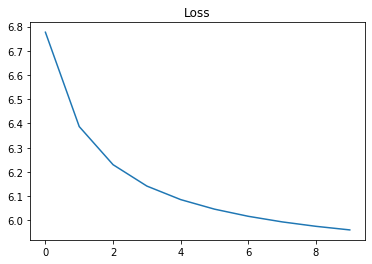

In [9]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(losses);

In [10]:
embeddings = model.embedding.weight.to('cpu').data.numpy()
embeddings

array([[ 0.41861993,  0.30127844, -0.27127403, ...,  0.16355942,
         0.4887048 , -0.2235172 ],
       [ 0.02317236,  0.3003777 ,  0.5754914 , ..., -0.35840005,
         0.29273605,  0.44586015],
       [-0.44855464,  0.40790072,  0.18012433, ..., -0.14043282,
         0.45408162, -0.5255303 ],
       ...,
       [-0.7081069 ,  2.4960709 , -0.35595477, ...,  0.67085797,
        -0.88499   , -0.14821377],
       [ 0.83577645,  1.0979055 , -0.6713738 , ...,  0.03800108,
        -1.713177  , -1.131172  ],
       [-0.602756  ,  0.28106523,  0.8749065 , ..., -0.24783304,
         0.5884725 ,  1.0725714 ]], dtype=float32)

In [11]:
def token_word_vector_map(embedding, token, text_dataset):
  token_index = text_dataset.word2index[token]
  token_vector = embedding[token_index]
  return token, token_vector

token_word_vector_map(embeddings, 'age', text_data)

('age', array([ 0.5200445 ,  0.02710764,  0.12281126, -0.4620838 , -0.9636117 ,
        -1.025562  ,  0.18111563, -0.3771408 , -0.39870328,  0.33100855,
        -1.377685  , -0.9918927 ,  0.6635051 , -0.6953625 , -1.7151538 ,
        -0.08024259,  0.6420326 , -0.6049179 ,  1.1265585 ,  0.2405316 ,
        -0.71775305, -0.6362314 , -0.20706071,  1.4148184 ,  0.90532196,
         0.11246099,  0.11275121, -0.64461493, -0.44959652, -0.8222408 ,
         0.9425076 ,  0.5909101 ,  2.0006285 , -0.23187251,  1.0112953 ,
        -1.55054   ,  0.48498082, -0.9421407 , -0.4420268 , -0.03296616,
         0.55842954, -0.07587308,  0.48185626,  1.3147432 ,  0.67269665,
        -1.7515491 , -2.0128815 ,  0.33190653, -1.2473239 , -0.51744246,
         0.25718442,  0.7074349 , -0.3930255 , -2.0249028 , -0.17189628,
        -0.16493946, -0.7787652 ,  0.5104636 , -0.15596108,  1.1091088 ,
        -0.77492136,  0.4902453 , -0.05742177,  0.6744657 ,  0.34086427,
         1.1058478 , -0.8508534 , -0.7261467

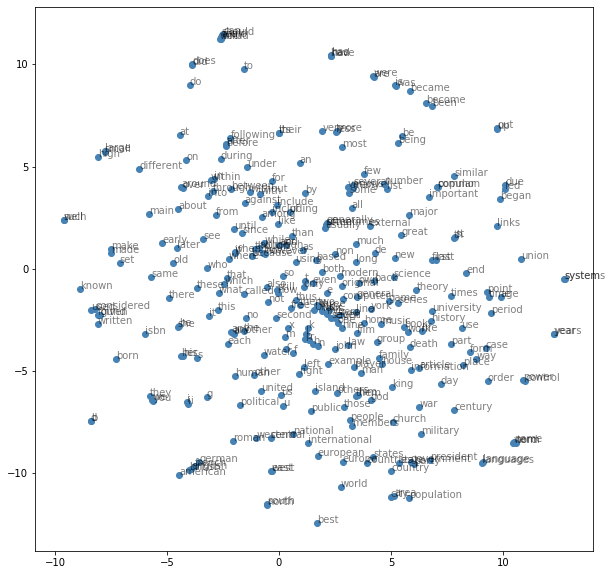

In [12]:
def visualization(embedding, text_dataset, number_words = 300):
  from sklearn.manifold import TSNE
  embed_tsne = TSNE(n_components=2).fit_transform(embedding[:number_words, :])
  fig, ax = plt.subplots(figsize=(10, 10))
  for idx in range(number_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(text_dataset.index2word[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.5)  
visualization(embeddings, text_data)

In [13]:
def intrinsic_evaluation_test(embeddings, text_data):
  capital_1 = 'Athens'.lower()
  country_1 = 'Greece'.lower()
  capital_2 = 'Beijing'.lower()
  country_2 = 'China'.lower()
  country_3 = 'Kenya'.lower()

  cap_1_idx = text_data.word2index[capital_1]
  cap_2_idx = text_data.word2index[capital_2]
  country_1_idx = text_data.word2index[country_1]
  country_2_idx = text_data.word2index[country_2]
  country_3_idx = text_data.word2index[country_3]

  cap_1_embed = embeddings[cap_1_idx]
  cap_2_embed = embeddings[cap_2_idx]
  country_1_embed = embeddings[country_1_idx]
  country_2_embed = embeddings[country_2_idx]
  country_3_embed = embeddings[country_3_idx]

  res = cap_1_embed + country_2_embed - country_1_embed
  print('Similarity (Athens + China - Greece :: Beijing): ',  np.dot(res, cap_2_embed) / (np.linalg.norm(res) * np.linalg.norm(cap_2_embed)))
  print('Similarity (Athens + China - Greece :: Kenya): ',  np.dot(res, country_3_embed) / (np.linalg.norm(res) * np.linalg.norm(country_3_embed)))

intrinsic_evaluation_test(embeddings, text_data)

Similarity (Athens + China - Greece :: Beijing):  0.5289558
Similarity (Athens + China - Greece :: Kenya):  0.012009969
